In [1]:
# Will Hollingsworth, Colton Murray, Alexander Shiveley

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Q1

By using the same method in the notes to expand the kernel function for some n and d, m can be found.  After expanding, and simplifying, m = number of terms in the polynomial.

c is set to 1.

To avoid tedious calculations, the expansions were done using sympy.

In [3]:
def get_m(n, d):
    """
    Expands and counts the terms in the polynomial kernel function for some n and d, where c = 1
    """
    # Supports n up to 4
    if n == 1:
        x1, z1 = sp.symbols('x1 z1')
        result = sp.expand((x1*z1+1)**d)
    elif n == 2:
        x1, z1, x2, z2 = sp.symbols('x1 z1 x2 z2')
        result = sp.expand((x1*z1+x2*z2+1)**d)
    elif n == 3:
        x1, z1, x2, z2, x3, z3 = sp.symbols('x1 z1 x2 z2 x3 z3')
        result = sp.expand((x1*z1+x2*z2+x3*z3+1)**d)
    elif n == 4:
        x1, z1, x2, z2, x3, z3, x4, z4 = sp.symbols('x1 z1 x2 z2 x3 z3 x4 z4')
        result = sp.expand((x1*z1+x2*z2+x3*z3+x4*z4+1)**d)    
    return str(result).count('+') + 1

# Find m for n = [1, 4], d = [1, 5]
for n in range(1, 5):
    for d in range(1, 6):
        print('n:', n, '  d:', d, '  m:', get_m(n, d))    

n: 1   d: 1   m: 2
n: 1   d: 2   m: 3
n: 1   d: 3   m: 4
n: 1   d: 4   m: 5
n: 1   d: 5   m: 6
n: 2   d: 1   m: 3
n: 2   d: 2   m: 6
n: 2   d: 3   m: 10
n: 2   d: 4   m: 15
n: 2   d: 5   m: 21
n: 3   d: 1   m: 4
n: 3   d: 2   m: 10
n: 3   d: 3   m: 20
n: 3   d: 4   m: 35
n: 3   d: 5   m: 56
n: 4   d: 1   m: 5
n: 4   d: 2   m: 15
n: 4   d: 3   m: 35
n: 4   d: 4   m: 70
n: 4   d: 5   m: 126


The most noticable pattern is that for some $n_1$, $d_1$, $n_2$, $d_2$ where $n_2 = d_1$ and $d_2 = n_1$, $m_1 = m_2$.
For example for $n = 2$, $d = 3$ and $n = 3$, $d = 2$, results in $m = 10$ for both cases.

This suggests there is some term in the relation like $n + d$ or $n * d$ involved for symmetry.

Another pattern is that for larger $n$ and $d$, $m$ grows large quickly. This suggests operations like exponents or factorials may be involved.

Using the above patterns, the final equation below was found to relate $n$, $d$, and $m$:

$$m = \frac{(n + d)!}{n! d!}$$

# Q2

# Getting the data into Python

In [4]:
# Load the txt as a numpy array of strings, 
# because it includes the column headers
raw_data = np.loadtxt('as6_data.txt', delimiter=' ', dtype=str)

# Convert everything into floats!
clean_data = np.array(raw_data, dtype=float)

clean_data

array([[243.,   3.,  -1.],
       [116., 165.,   1.],
       [198., 127.,  -1.],
       [184., 234.,   1.],
       [165., 231.,   1.],
       [160.,  46.,  -1.],
       [ 70., 169.,   1.],
       [300.,  94.,  -1.],
       [ 95.,  62.,  -1.],
       [ 61., 186.,   1.],
       [ 79., 140.,   1.],
       [245., 185.,  -1.],
       [264.,   2.,  -1.],
       [192., 146.,  -1.],
       [274., 104.,  -1.],
       [170.,  37.,  -1.],
       [172., 144.,  -1.],
       [222., 131.,  -1.],
       [ 35., 204.,   1.],
       [105., 199.,   1.],
       [146.,  40.,  -1.],
       [ 35.,  68.,   1.],
       [221.,  41.,  -1.],
       [ 39.,  16.,  -1.],
       [ 18.,  77.,   1.],
       [ 32., 134.,   1.],
       [ 21.,  61.,   1.],
       [109., 266.,   1.],
       [134., 172.,   1.],
       [100., 183.,   1.],
       [ 45., 158.,   1.],
       [263., 193.,  -1.],
       [173.,  88.,  -1.],
       [299.,  98.,  -1.],
       [ 81., 240.,   1.],
       [ 69., 235.,   1.],
       [152., 189.,   1.],
 

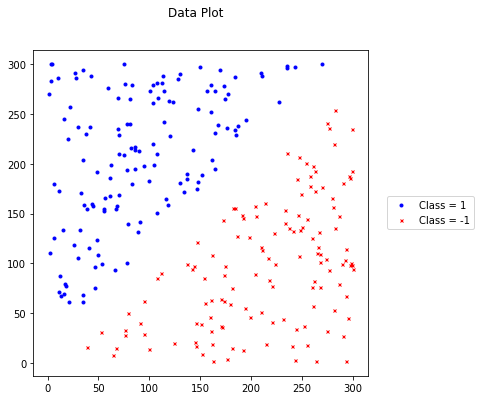

In [5]:
def split_pos_neg(data):
    """
    Returns two sets of positive, then negative examples (1's then -1's from the output column)
    """
    return data[data[:, -1]==1, :-1], data[data[:, -1]==-1, :-1]

pos, neg = split_pos_neg(clean_data)

x1_pos = pos[:, 0].flatten()
x2_pos = pos[:, 1].flatten()
x1_neg = neg[:, 0].flatten()
x2_neg = neg[:, 1].flatten()

plt.figure(figsize=(6,6))
plt.plot(x1_pos,x2_pos,'bo', markersize=3)
plt.plot(x1_neg,x2_neg,'rx', markersize=3)
plt.suptitle('Data Plot')
plt.legend(['Class = 1', 'Class = -1'],bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

In [6]:
def get_sets(data, split):
    """
    Convenience function that randomly selects a training and test set from the input data.
    
    :param data: (ndarray) the data you want to split
    :param split: (float array) the percentages of the data you want to be TRAINING, VALIDATION, and TESTING data
    
    :returns: (tuple) a tuple where the first element is the training set, and the second element is the test set
    """
    # Randomly shuffle the order from a copy of the data
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    row_count = data.shape[0]

    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split)
    
    training_set = shuffled[:training_count]
    test_set = shuffled[training_count:]
    
    return training_set, test_set

In [7]:
training, test = get_sets(clean_data, .5)

# Initializing alpha

In [8]:
import random

def init_lagrange_multipliers(data):
    # Find positions where the labels are -1, and 1 respectively
    neg = np.where(data[:, 2] == -1)[0]
    pos = np.where(data[:, 2] == 1)[0]
    
    y = data[:, 2]
    alpha = np.array([random.randint(0, 100) for _ in y], dtype=float)
    
    # Calculate the sum of the product of the labels and alpha values
    t = sum(y * np.transpose(alpha))
    
    # If the sum is positive, 
    # then increment a random alpha value corresponding to a negative label
    while t > 0:
        i = np.random.choice(neg)
        alpha[i] += 1
        t = sum(y * np.transpose(alpha))
        
    # If the sum is negative, 
    # then increment a random alpha value corresponding to a positive label
    while t < 0:
        i = np.random.choice(pos)
        alpha[i] += 1
        t = sum(y * np.transpose(alpha))
        
    return alpha

In [9]:
alpha = init_lagrange_multipliers(training)
print(alpha)

# Initialize b to 0
b = 0

[ 79.  36.  51.  97.  93.  57. 105.  52.  84.  23.  88.  48.  61. 104.
  98.  13.  13.  87.  76.   1.  29.  42.  76. 104.  70.  40. 113.  24.
  27.  36.  99.  51.   3.   9.  37.  45.  68.   2.  15.  46.  48.  88.
  80.  85.  31. 103.  52.  74.  48.  75.  67.  42.  97.  28.  88.  39.
  28.  27.  47.  26. 106.  75.  60.  51.  79.  72.  15.  13.  89.  26.
  63.  18.  94.  40.  70. 104.  58.  18.  34.  16.  98.  88.  11.  79.
  28. 100.  46.  90. 110.  60.  25.  84.  48.  96. 111.  71.  28.  57.
  67.  91. 103.  95.  42.  51.  56.  53.  78.  66.  31.  36.  97.  27.
  56.  30.  93.  28.  62. 100.  62.  62.  87.  72.  63.  31.  65.  80.
  59.  85.  96.  91.  27. 116.  30.]


In [10]:
sum(training[:, 2] * np.transpose(alpha))

0.0

# SMO Algorithm

In [11]:
# Lets make a helper function to split up our X and Y matrices
def split_input_output(data):
    """
    Splits the input array into two seperate sets:
        * the feature values
        * the output value
        
    :returns: (tuple) the features are the first element, the outputs are the second
    """
    return np.delete(data, [data.shape[1] - 1], axis=1), data[:, -1]

def get_weights():
    # Always use x_train, y_train?
    vec = np.zeros(x_train.shape[1])
    for i in range(y_train.shape[0]):
        vec += alpha[i] * y_train[i] * x_train[i]
    return vec

x_train, y_train = split_input_output(training)
x_test, y_test = split_input_output(test)

weights = get_weights()

weights

array([-473013.,  437310.])

In [12]:
def classify(x, i):
    # classify values > 0 to 1, otherwise -1
    weights = get_weights()
    return np.sign(np.dot(weights, x[i]) + b)

def KKT(x, y, i):
    weights = get_weights()
    return alpha[i] * (y[i] * (np.dot(weights, x[i]) + b) - 1)

def K(x, i, j):
    return np.dot(x[i], x[j])

def E(x, y, i):
    val = 0
    for j in range(y.shape[0]):
        val += alpha[j] * y[j] * K(x, j, i)
    return val - y[i]

def e(x, y, i1, i):
    return E(x, y, i1) - E(x, y, i)

# Helper argmax function
def argmax(f, x):
    vec_fn = np.vectorize(f)
    
    return np.argmax(vec_fn(x))

In [13]:
def accuracy(classified_y, test_y):
    comp = (classified_y == test_y)
    return np.count_nonzero(comp) / len(comp)

def classify_data(x):
    return np.array([classify(x, i) for i in range(x.shape[0])])

# Update alpha until classified. Using accuracy to test. (Steps 2 - 9)

In [14]:
accuracy(classify_data(x_test), y_test)

1.0

In [15]:
while accuracy(classify_data(x_train), y_train) < 1:
    i1 = argmax(lambda i: KKT(x_train, y_train, i), range(y_train.shape[0]))
    x1 = x_train[i1]
    i2 = argmax(lambda i: e(x_train, y_train, i1, i), range(y_train.shape[0]))
    x2 = x_train[i2]    
    
    # Calc k = K11 + K22 - 2K12
    k = K(x_train, i1, i1) + K(x_train, i2, i2) - (2 * K(x_train, i1, i2))
    
    # Update alpha 2
    old_alpha_2 = alpha[i2]
    alpha[i2] = old_alpha_2 + ((y_train[i2] * e(x_train, y_train, i1, i2)) / k)
    
    # Update alpha 1
    alpha[i1] = alpha[i1] + (y_train[i1] * y_train[i2] * (old_alpha_2 - alpha[i2]))
    
    # Prune alphas
    for i in range(len(alpha)):
        if alpha[i] < .1:  # TODO make variable epsilon as a parameter
            alpha[i] = 0
    
    # Calc b, I dunno man I was just tryin to average them... I can't remember how she said to do it
    s = 0
    for i in np.where(alpha > 0)[0]:
        s += (((KKT(x_train, y_train, i) / alpha[i]) + 1) / y_train[i]) - np.dot(get_weights(), x_train[i])
        
    s /= len(np.where(alpha > 0)[0])
    b = s
    print("B = ", b)
        
    
    acc = accuracy(classify_data(x_train), y_train)
    print('New Accuracy:', acc)